# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [9]:
# 草稿
a = np.array([4,6,2,65,3,67])
max_idx = np.argmax(a)
max_score = a[max_idx]
print(max_score)
softmax = np.exp(max_score)/np.sum(np.exp(a))
print(softmax)
print(-np.log(softmax))
# softmax损失函数导数推导过程在笔记里

67
0.8807970779778824
0.12692801104297252


In [36]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.305956
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *因为刚开始W中的参数是随机的，所以分类器输出的类概率1/10，损失为大概为-log（1/10）* 



In [40]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.642499 analytic: 0.642499, relative error: 6.101952e-09
numerical: 1.394801 analytic: 1.394800, relative error: 5.018129e-08
numerical: -3.607251 analytic: -3.607251, relative error: 1.105786e-09
numerical: 1.837641 analytic: 1.837641, relative error: 6.285309e-09
numerical: 0.036969 analytic: 0.036969, relative error: 1.929126e-06
numerical: -0.094869 analytic: -0.094869, relative error: 1.000747e-06
numerical: 0.229499 analytic: 0.229499, relative error: 1.357089e-07
numerical: -0.334937 analytic: -0.334937, relative error: 2.843013e-07
numerical: 0.672698 analytic: 0.672698, relative error: 4.926607e-08
numerical: -2.260468 analytic: -2.260469, relative error: 3.675204e-08
numerical: -0.212283 analytic: -0.212283, relative error: 1.256676e-08
numerical: 1.490550 analytic: 1.490549, relative error: 5.964530e-08
numerical: 1.861589 analytic: 1.861589, relative error: 3.109582e-08
numerical: 0.112583 analytic: 0.112583, relative error: 8.389214e-07
numerical: 0.968917 anal

In [50]:
# 草稿
a = [1,1,1,2,2,2]
data = np.random.randint(1, 100, (6, 10))
print(data)
print(data[range(6), list(a)])
print(np.sum(np.exp(data), axis=1))

a = np.exp(data)
print(a)
b = np.sum(np.exp(data), axis=1)
print(b)
print(a / b.reshape(-1, 1))

# numpy深拷贝
a = np.array([1, 2, 3])
b = a.copy()
b[0] = 2
print(a)

[[97 26 72 81 19 95 53  6 17 16]
 [79 78 39 70 70 51 74 20 26 46]
 [62  1 74 44 17 46 30 16 49 84]
 [88 70 95 90 41 48 40 15 64 99]
 [ 3 46 49 92 65 12 74 90 50 35]
 [ 7 72 81 53 75  6 67 64 13 68]]
[26 78  1 95 49 81]
[1.51945878e+42 2.80235968e+34 3.02521466e+36 1.00715398e+43
 1.02380318e+40 1.51002114e+35]
[[1.33833472e+42 1.95729609e+11 1.85867175e+31 1.50609731e+35
  1.78482301e+08 1.81123908e+41 1.04137594e+23 4.03428793e+02
  2.41549528e+07 8.88611052e+06]
 [2.03828107e+34 7.49841700e+33 8.65934004e+16 2.51543867e+30
  2.51543867e+30 1.40934908e+22 1.37338298e+32 4.85165195e+08
  1.95729609e+11 9.49611942e+19]
 [8.43835667e+26 2.71828183e+00 1.37338298e+32 1.28516001e+19
  2.41549528e+07 9.49611942e+19 1.06864746e+13 8.88611052e+06
  1.90734657e+21 3.02507732e+36]
 [1.65163625e+38 2.51543867e+30 1.81123908e+41 1.22040329e+39
  6.39843494e+17 7.01673591e+20 2.35385267e+17 3.26901737e+06
  6.23514908e+27 9.88903032e+42]
 [2.00855369e+01 9.49611942e+19 1.90734657e+21 9.01762841e+3

In [55]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.305956e+00 computed in 0.150453s
vectorized loss: 2.305956e+00 computed in 0.004913s
Loss difference: 0.000000
Gradient difference: 0.000000


In [58]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for re in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=re, num_iters=1000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, re)] = [train_accuracy, val_accuracy]
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 776.667878
iteration 100 / 1000: loss 285.230795
iteration 200 / 1000: loss 105.790906
iteration 300 / 1000: loss 39.967340
iteration 400 / 1000: loss 15.944088
iteration 500 / 1000: loss 7.114343
iteration 600 / 1000: loss 3.958644
iteration 700 / 1000: loss 2.785201
iteration 800 / 1000: loss 2.309189
iteration 900 / 1000: loss 2.159225
iteration 0 / 1000: loss 1525.829455
iteration 100 / 1000: loss 205.458629
iteration 200 / 1000: loss 29.289814
iteration 300 / 1000: loss 5.761996
iteration 400 / 1000: loss 2.639866
iteration 500 / 1000: loss 2.201943
iteration 600 / 1000: loss 2.197751
iteration 700 / 1000: loss 2.184767
iteration 800 / 1000: loss 2.167660
iteration 900 / 1000: loss 2.105861
iteration 0 / 1000: loss 778.075312
iteration 100 / 1000: loss 6.991379
iteration 200 / 1000: loss 2.104116
iteration 300 / 1000: loss 2.150243
iteration 400 / 1000: loss 2.044805
iteration 500 / 1000: loss 2.068641
iteration 600 / 1000: loss 2.134734
iteration 700 / 10

In [64]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$True


$\color{blue}{\textit Your Explanation:}$SVM分类器要求正确的分类比错误的分类的分数高出一个值，所以新加入一个数据可能的损失为0，但是softMax是以概率的形式计算损失，除非新加入的数据的正确的分类分数无限大，但是这种情况不太可能，所以肯定会有损失。




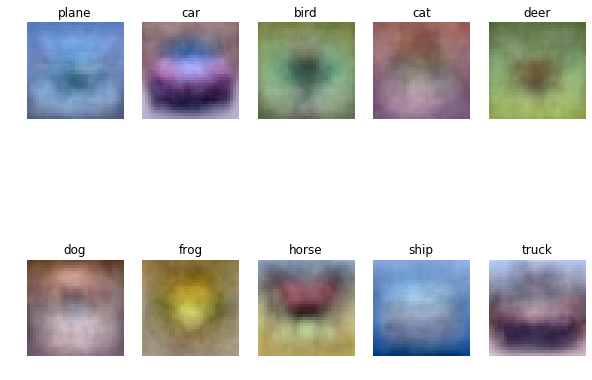

In [65]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])